# Stochastic differential equations

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la
import ladynamic as lad

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import networkx as nx

$$
\frac{dx}{dt} = a_{x,0} - a_{x,y} y - d_{x} x
$$
$$
\frac{dy}{dt} = a_{y,0} - a_{y,x} x - d_{y} y
$$

In [5]:
from latenta.variables import VariablePromise, RandomPromise


class dgene(la.Computed):
    x = VariablePromise()
    y = VariablePromise()
    a_0 = VariablePromise()
    a_x = VariablePromise()
    a_y = VariablePromise()
    k_x = VariablePromise()
    k_y = VariablePromise()
    p = VariablePromise()
    d = VariablePromise()
    e = RandomPromise()


class dx(dgene):
    def __call__(self, x, y, a_0, a_x, a_y, k_x, k_y, p, d, e):
        y_activity = (y / k_y) ** 2
        x_activity = (x / k_x) ** 2
        return (
            p
            * (a_0 + a_y * y_activity + a_x * x_activity)
            / (1 + y_activity + x_activity)
            - d * x
            + e
        )


class dy(dgene):
    def __call__(self, x, y, a_0, a_x, a_y, k_x, k_y, p, d, e):
        y_activity = (y / k_y) ** 2
        x_activity = (x / k_x) ** 2
        return (
            p
            * (a_0 + a_y * y_activity + a_x * x_activity)
            / (1 + y_activity + x_activity)
            - d * y
            + e
        )

-----

In [6]:
x_initial = la.Fixed(0.0)
y_initial = la.Fixed(0.0)

In [7]:
e_x = la.distributions.Normal(scale=2.0)
e_y = la.distributions.Normal(scale=2.0)

In [8]:
simulations = la.Dim(20, "simulation")

In [10]:
x = lad.State(x_initial, definition=la.Definition([simulations]), label="x")
y = lad.State(y_initial, definition=la.Definition([simulations]), label="y")

In [11]:
x.derivative = dx(x, y, a_0=1 / 4, a_x=1, a_y=0, k_x=1, k_y=1.0, d=1.0, p=5.0, e=e_x)
y.derivative = dy(x, y, a_0=1 / 4, a_y=1, a_x=0, k_y=1, k_x=1.0, d=1.0, p=5.0, e=e_y)

In [13]:
final_time = la.Fixed(20.0)

x_extractor = lad.extractors.EachExtractor(x, final_time)
y_extractor = lad.extractors.EachExtractor(y, final_time)

extractors = [x_extractor, y_extractor]

In [14]:
dt = la.Fixed(0.01)
states = [x, y]
dynamics = lad.solvers.Euler(
    states, extractors, dt, extra_dependent=(x.derivative.e, y.derivative.e)
)

In [16]:
time = dynamics.time
time_extractor = lad.extractors.EachExtractor(time, final_time)
dynamics.add_extractors(time_extractor)


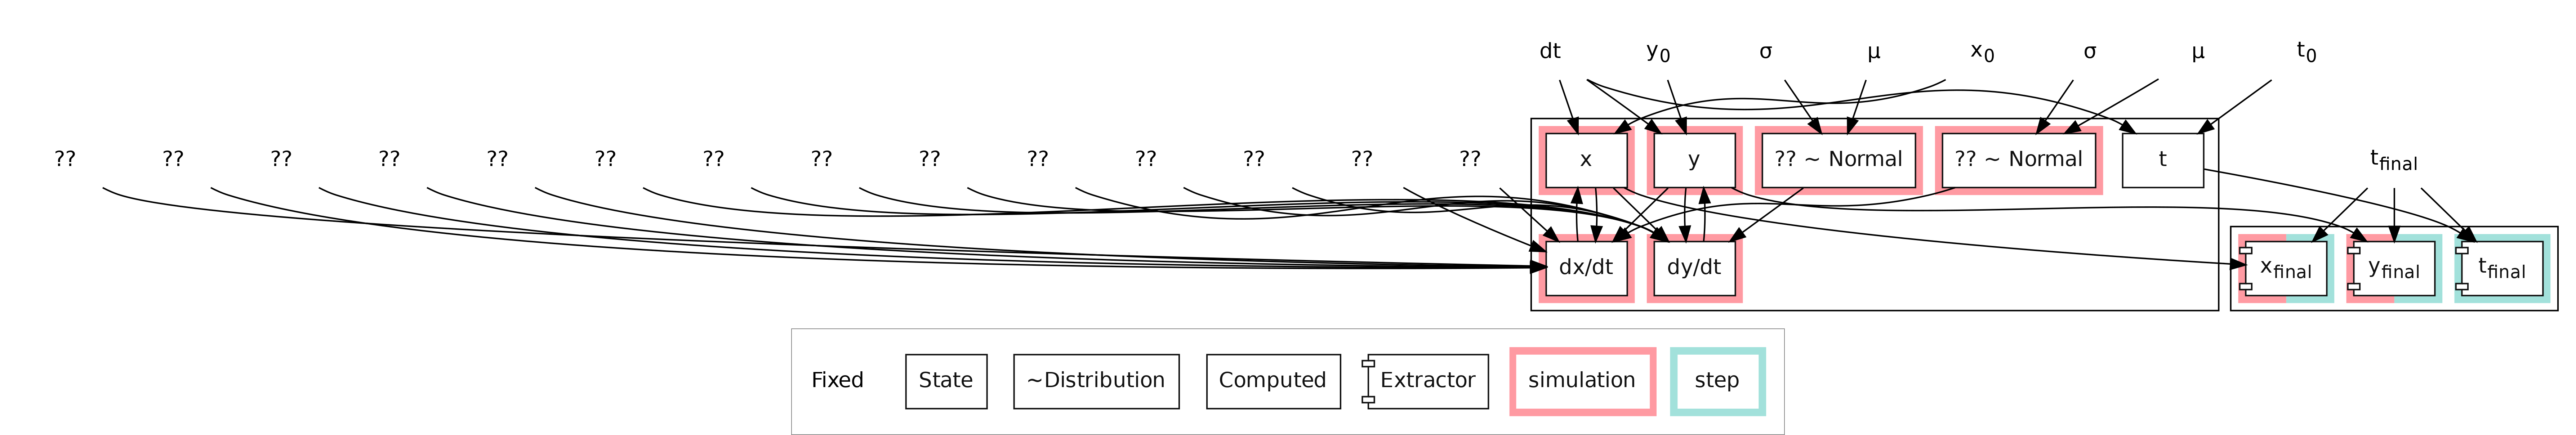

In [17]:
model = la.Root(x_extractor, y_extractor, time_extractor)
model.plot()

In [18]:
posterior = la.posterior.Posterior(model)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
time_values = (
    posterior.samples[time_extractor]
    .sel(sample=0)
    .broadcast_like(posterior.samples[x_extractor].sel(sample=0))
)
steps = xr.concat(
    [
        posterior.samples[x_extractor].sel(sample=0),
        posterior.samples[y_extractor].sel(sample=0),
        time_values,
    ],
    dim=pd.Series(["x", "y", "time"], name="state"),
)

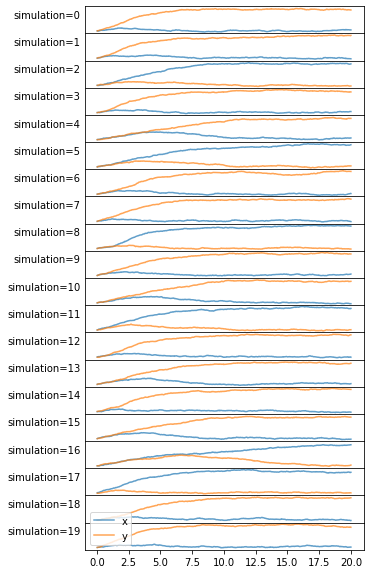

In [20]:
design = pd.DataFrame({"simulation": range(len(simulations))})

fig, axes = plt.subplots(
    design.shape[0],
    1,
    figsize=(5, 0.5 * design.shape[0]),
    gridspec_kw={"hspace": 0},
    sharey=True,
)


def extract_run(**kwargs):
    rundata = steps.sel(**kwargs).to_pandas().T
    rundata["name"] = ",".join(f"{key}={value}" for key, value in kwargs.items())
    return rundata


for ax, (ix, row) in zip(axes, design.iterrows()):
    plotdata = extract_run(simulation=row["simulation"])
    ax.plot(plotdata["time"], plotdata["x"], alpha=0.7, label="x")
    ax.plot(plotdata["time"], plotdata["y"], alpha=0.7, label="y")
    ax.set_ylabel(plotdata["name"][0], rotation=0, ha="right")
    ax.set_yticks([])
plt.legend()

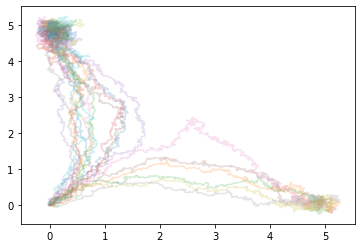

In [21]:
fig, ax = plt.subplots()
for (ix, row) in design.iterrows():
    plotdata = extract_run(simulation=row["simulation"])
    ax.plot(plotdata["x"], plotdata["y"], label=plotdata["name"][0], alpha=0.2)
# plt.legend()